# Example: noisy identity process on one qubit

This example is featured in the paper.


**Contents:**
* [Python initializations](#Python-initializations)
* [Data set-up](#Data-set-up)
* [Bipartite sampling method](#Bipartite-sampling-method)
* [Bipartite sampling method, optimized](#Bipartite-sampling-method,-optimized)
* [Fit with our empirical model \#2](#Fit-with-our-empirical-model-#2)
* [Bipartite sampling method, optimize, entanglement fidelity](#Bipartite-sampling-method,-optimized,-entanglement-fidelity)
* [Bipartite sampling method, optimize, worst-case entanglement fidelity](#Bipartite-sampling-method,-optimized,-worst-case-entanglement-fidelity)
* [Prepare data for channel-space methods](#Prepare-data-for-channel-space-methods)
* [Channel-space method, "$e^{iH}$" variant](#Channel-space-method,-%22$e^{iH}$%22-variant)
* [Channel-space method, "elementary rotations" variant](#Channel-space-method,-%22elementary-rotation%22-variant)
* [Channel-space method, "elementary rotations" variant, entanglement fidelity](#Channel-space-method,-%22elementary-rotation%22-variant,-entanglement-fidelity)
* [Channel-space method, "elementary rotations" variant, worst-case entanglement fidelity](#Channel-space-method,-%22elementary-rotation%22-variant,-worst-case-entanglement-fidelity)
* [Grand comparison plots](#Grand-comparison-plots)


## Python initializations

In [3]:
import os.path
import sys
import datetime

import numpy as np
import matplotlib.pyplot as plt

import dnormtomo
import dnormtomo.channelspace
import dnormtomo.bistates
import dnormtomo.util
print("Using dnormtomo version {}".format(dnormtomo.__version__))

import qutip

import tomographer
import tomographer.jpyutil
import tomographer.querrorbars
print("Using tomographer version {}".format(tomographer.__version__))

# to save & load computation results
try:
    import cPickle as pickle
except:
    import pickle

# interact with plots in notebook
%matplotlib notebook

Using dnormtomo version 0.9
Using tomographer version v5.3-65-g44f6a8d


In [18]:
# utilities for storing & loading calculation results
def save_to_cache(cachesuffix, x):
    with open('_CACHE_'+cachesuffix+'.dat', 'wb') as f:
        pickle.dump(x, f, 2)
def load_from_cache(cachesuffix):
    cachefile = '_CACHE_'+cachesuffix+'.dat'
    if not os.path.exists(cachefile):
        return None
    with open(cachefile, 'rb') as f:
        display(Markdown("Loading `{}` from cache".format(cachesuffix)))
        return pickle.load(f)

In [4]:
#
# number of outcomes per Pauli pairs
#
NumSamplesPerSetting = 500
# Pauli measurement settings on one system
PauliMeasSettings = [
    [
        dnormtomo.util.projpauli(i, s)
        for s in [1, -1]
    ]
    for i in [1, 2, 3]
]
# simulate the measurements
sigmareal_X = qutip.Qobj(np.array([[ 0.6, 0.01], [0.01, 0.4]]))
Ereal_XY = qutip.Qobj(np.array([[ 0.95, 0, 0, 0.95],
                                [ 0, 0.05, 0, 0],
                                [ 0, 0,    0, 0],
                                [ 0.95, 0, 0, 1],
                               ]), dims=[[2,2],[2,2]])
def simulate_measurements():
    d = dnormtomo.util.simulate_process_measurements(sigmareal_X, Ereal_XY, PauliMeasSettings, PauliMeasSettings,
                                                     NumSamplesPerSetting)
    
    with open('meas_data.dat', 'wb') as f:
        pickle.dump(d, f)
        
    return d

#
# Only simulate the measurements once. After that, use the same data when comparing methods!!
#
if not os.path.exists('meas_data.dat'):
    d = simulate_measurements()
else:
    with open('meas_data.dat', 'rb') as f:
        d = pickle.load(f)

#print(d.__dict__) # should print Emn, Nm

In [5]:
#
# Stuff for the analysis, later
#
def print_report(r):
    print("Calculation ran for {!s} seconds".format(datetime.timedelta(seconds=r['elapsed_seconds'])))
    print(r['final_report_runs'])

def do_analysis(r, name, plots=False, ftox=(0,1)):
    final_histogram = r['final_histogram']
    analysis = tomographer.querrorbars.HistogramAnalysis(final_histogram, threshold_fraction=1e-3, ftox=ftox)
    fitparams = analysis.printFitParameters()
    analysis.printQuantumErrorBars()
    
    p1 = None
    p2 = None
    
    if plots:
        p1 = analysis.plot(show_plot=False) # linear scale
        p1.ax.set_title("Distribution of the diamond norm: " + name)
        p1.ax.set_xlabel('Diamond Norm distance to the identity channel')
        p1.show()

        p2 = analysis.plot(log_scale=True, show_plot=False) # log scale
        p2.ax.set_title("Distribution of the diamond norm: " + name)
        p2.ax.set_xlabel('Diamond Norm distance to the identity channel')
        p2.show()
    
    return {'r': r, 'name': name, 'analysis': analysis, 'fitparams': fitparams, 'p1': p1, 'p2': p2}


# Naive method

In [6]:
r_naive = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_naive = dnormtomo.bistates.run(
        dimX=2, dimY=2, Emn=d.Emn, Nm=np.array(d.Nm),
        hist_params=tomographer.HistogramParams(0, 0.2, 50),
        mhrw_params=tomographer.MHRWParams(0.008, 125, 2048, 32768),
        progress_fn=prg.progress_fn
        )
    prg.displayFinalInfo(r_naive['final_report_runs'])
print_report(r_naive)

Calculation ran for 0:05:23.255854 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.008
	# iter. / sweep = 125
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0|           ....+x###x+-.....                      |0.2                   [accept ratio = 0.24]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#1: 0|           ....+x###x+-.......                    |0.2                   [accept ratio = 0.24]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#2: 0|           ....+x###x+-.....                      |0.2                   [accept ratio = 0.24]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#3: 0|           ....+x###x+-......                     |0.2                   [accept ratio = 0.24]
    error bars: 49 converged / 1 

In [19]:
save_to_cache('r_naive', r_naive)

In [7]:
a_naive = do_analysis(r_naive, 'Naive')

Fit parameters:
          a2 = 3.86245e-12
          a1 = 1074.04
           m = 79.3562
           c = 289.97
Quantum Error Bars:
          f0 = 0.07389
       Delta = 0.01173
       gamma = 0.0006207



# Naive method, optimized

In [8]:
r_naiveopt = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_naiveopt = dnormtomo.bistates.run(
        dimX=2, dimY=2, Emn=d.Emn, Nm=np.array(d.Nm),
        hist_params=tomographer.HistogramParams(0, 0.2, 50),
        mhrw_params=tomographer.MHRWParams(0.008, 512, 32768, 32768), # thermalize a lot
        progress_fn=prg.progress_fn,
        jumps_method='light' # use optimized random walk
        )
    prg.displayFinalInfo(r_naiveopt['final_report_runs'])
print_report(r_naiveopt)

Calculation ran for 0:04:57.438952 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.008
	# iter. / sweep = 512
	# therm. sweeps = 32768
	# run sweeps    = 32768
#0: 0|            ...+x###x+-.......                    |0.2                   [accept ratio = 0.26]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#1: 0|           ....+x###x+-......                     |0.2                   [accept ratio = 0.26]
    error bars: 48 converged / 2 maybe (2 isolated) / 0 not converged
#2: 0|          .....+x##%x+-.....                      |0.2                   [accept ratio = 0.26]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#3: 0|           ....+x###x+-......                     |0.2                   [accept ratio = 0.26]
    error bars: 48 converged / 2

In [20]:
save_to_cache('r_naiveopt', r_naiveopt)

In [9]:
a_naiveopt = do_analysis(r_naiveopt, 'Naive, opt.')

Fit parameters:
          a2 = 3.58581e-18
          a1 = 1062.51
           m = 78.4267
           c = 286.693
Quantum Error Bars:
          f0 = 0.07381
       Delta = 0.01179
       gamma = 0.0006274



# Naive method, optimized, entanglement fidelity

In [10]:
r_Fe_naiveopt = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_Fe_naiveopt = dnormtomo.bistates.run(
        dimX=2, dimY=2, Emn=d.Emn, Nm=np.array(d.Nm),
        fig_of_merit='entanglement-fidelity',
        hist_params=tomographer.HistogramParams(0.9, 1.0, 50),
        mhrw_params=tomographer.MHRWParams(0.008, 512, 32768, 32768), # thermalize a lot
        progress_fn=prg.progress_fn,
        jumps_method='light' # use optimized random walk
        )
    prg.displayFinalInfo(r_Fe_naiveopt['final_report_runs'])
print_report(r_Fe_naiveopt)

Calculation ran for 0:00:50.673371 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.008
	# iter. / sweep = 512
	# therm. sweeps = 32768
	# run sweeps    = 32768
#0: 0.9|         ........-ox%###xo-.......                |1                   [accept ratio = 0.27]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#1: 0.9|       .. .......-+x%###xo-......                 |1                   [accept ratio = 0.25]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#2: 0.9|         ........-+x%###xo-.....                  |1                   [accept ratio = 0.26]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#3: 0.9|          .......-ox####xo-.....                  |1                   [accept ratio = 0.27]
    error bars: 50 converged / 0

In [21]:
save_to_cache('r_Fe_naiveopt', r_Fe_naiveopt)

In [11]:
a_Fe_naiveopt = do_analysis(r_Fe_naiveopt, 'Naive, opt.', ftox=(1,-1))

Fit parameters:
          a2 = 4938.33
          a1 = 726.228
           m = 70.9512
           c = 264.944
Quantum Error Bars:
          f0 = 0.9444
       Delta = 0.007808
       gamma = 0.0002553



# Naive method, optimized, worst-case entanglement fidelity

In [12]:
r_wFe_naiveopt = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_wFe_naiveopt = dnormtomo.bistates.run(
        dimX=2, dimY=2, Emn=d.Emn, Nm=np.array(d.Nm),
        fig_of_merit='worst-entanglement-fidelity',
        hist_params=tomographer.HistogramParams(0.85, 1.0, 50),
        mhrw_params=tomographer.MHRWParams(0.008, 512, 32768, 1024), # thermalize a lot
        progress_fn=prg.progress_fn,
        jumps_method='light' # use optimized random walk
        )
    prg.displayFinalInfo(r_wFe_naiveopt['final_report_runs'])
print_report(r_wFe_naiveopt)

Calculation ran for 0:00:28.155255 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.008
	# iter. / sweep = 512
	# therm. sweeps = 32768
	# run sweeps    = 1024
#0: 0.85|                  ....--oo%#%%+-.. .              |1 [+0.001 off]     [accept ratio = 0.27]
    error bars: 48 converged / 2 maybe (2 isolated) / 0 not converged
#1: 0.85|                .....--+o####%o-..                |1                  [accept ratio = 0.28]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#2: 0.85|                ......-+ox%##%o+....              |1 [+0.0005 off]    [accept ratio = 0.25]
    error bars: 45 converged / 5 maybe (1 isolated) / 0 not converged
#3: 0.85|                 .....-+o%###%o-....              |1 [+0.0005 off]    [accept ratio = 0.28]
    error bars: 48 converged / 2 

In [22]:
save_to_cache('r_Fe_naiveopt', r_Fe_naiveopt)

In [13]:
a_wFe_naiveopt = do_analysis(r_wFe_naiveopt, 'worst-Fe, Naive, opt.', ftox=(1,-1))

Fit parameters:
          a2 = 8.377e-14
          a1 = 1055.39
           m = 71.41
           c = 267.493
Quantum Error Bars:
          f0 = 0.9323
       Delta = 0.01132
       gamma = 0.0006317



# Channel-space methods

In [14]:
# we need to encode the input state in the POVM effects

sigmareal_X_sqrtm_eyeY = np.kron(sigmareal_X.sqrtm().data.toarray(), np.eye(2))
Emn_for_channelspace = [
    np.dot(np.dot(sigmareal_X_sqrtm_eyeY, E), sigmareal_X_sqrtm_eyeY)
    for E in d.Emn
]

## Channel-space method with $e^{iH}$ jumps

In [15]:
r_eiH = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_eiH = dnormtomo.channelspace.run(
        dimX=2, dimY=2, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
        hist_params=tomographer.HistogramParams(0, 0.2, 50),
        channel_walker_jump_mode=dnormtomo.channelspace.RandHermExp,
        mhrw_params=tomographer.MHRWParams(0.01, 100, 2048, 32768),
        progress_fn=prg.progress_fn
        )
    prg.displayFinalInfo(r_eiH['final_report_runs'])
print_report(r_eiH)

Calculation ran for 0:10:10.965726 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.01
	# iter. / sweep = 100
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0|           ....+x##%o+-.....                      |0.2                   [accept ratio = 0.24]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#1: 0|           ....+x##%o+-.....                      |0.2                   [accept ratio = 0.24]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#2: 0|           ....+x##%x+-......                     |0.2                   [accept ratio = 0.24]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#3: 0|           ....+x##%o+-......                     |0.2                   [accept ratio = 0.24]
    error bars: 49 converged / 1 m

In [16]:
a_eiH = do_analysis(r_eiH, 'e^{iH} jumps')

Fit parameters:
          a2 = 4.27176e-09
          a1 = 1089.3
           m = 79.6712
           c = 291.926
Quantum Error Bars:
          f0 = 0.07314
       Delta = 0.01159
       gamma = 0.000612



## Channel-space method with "elementary-rotation" jumps

In [17]:
r_elr = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_elr = dnormtomo.channelspace.run(
        dimX=2, dimY=2, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
        hist_params=tomographer.UniformBinsHistogramParams(0, 0.2, 50),
        channel_walker_jump_mode=dnormtomo.channelspace.ElemRotations,
        mhrw_params=tomographer.MHRWParams(0.02, 50, 2048, 32768),
        progress_fn=prg.progress_fn
        )
    prg.displayFinalInfo(r_elr['final_report_runs'])
print_report(r_elr)

Calculation ran for 0:07:28.769911 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.02
	# iter. / sweep = 50
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0|           ....+x##%o+-.....  .                   |0.2                   [accept ratio = 0.24]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#1: 0|          .....+x###x+-......                     |0.2                   [accept ratio = 0.24]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#2: 0|           ....+x##%o+-..... .                    |0.2                   [accept ratio = 0.24]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#3: 0|           ....+x##%x+-......                     |0.2                   [accept ratio = 0.25]
    error bars: 50 converged / 0 ma

In [17]:
a_elr = do_analysis(r_elr, '"elem. rotation" jumps')

Fit parameters:
          a2 = 14.3387
          a1 = 489.087
           m = 33.7066
           c = 127.453
Quantum Error Bars:
          f0 = 0.06864
       Delta = 0.01669
       gamma = 0.001347



## Channel-space method with "elementary-rotation" jumps, entanglement fidelity

In [18]:
r_Fe_elr = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_Fe_elr = dnormtomo.channelspace.run(
        dimX=2, dimY=2, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
        fig_of_merit='entanglement-fidelity',
        hist_params=tomographer.UniformBinsHistogramParams(0.9, 1.0, 50),
        channel_walker_jump_mode=dnormtomo.channelspace.ElemRotations,
        mhrw_params=tomographer.MHRWParams(0.02, 50, 2048, 32768),
        progress_fn=prg.progress_fn
        )
    prg.displayFinalInfo(r_Fe_elr['final_report_runs'])
print_report(r_Fe_elr)

Calculation ran for 0:03:02.171248 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.02
	# iter. / sweep = 50
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0.9|            .........--+ox%###%xo-......          |1                   [accept ratio = 0.24]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#1: 0.9|             ........--+ox%###%xo+-.....          |1                   [accept ratio = 0.24]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#2: 0.9|             ........--+ox%####xo--.... .         |1                   [accept ratio = 0.24]
    error bars: 48 converged / 2 maybe (2 isolated) / 0 not converged
#3: 0.9|          ...........--+ox%###%xo+-.....          |1                   [accept ratio = 0.24]
    error bars: 49 converged / 0 ma

In [19]:
a_Fe_elr = do_analysis(r_Fe_elr, '"elem. rotation" jumps', ftox=(1,-1))

Fit parameters:
          a2 = 1207.3
          a1 = 759.588
           m = 37.0364
           c = 155.525
Quantum Error Bars:
          f0 = 0.9571
       Delta = 0.009421
       gamma = 0.0006157



## Channel-space method with "elementary-rotation" jumps, worst-case entanglement fidelity

In [20]:
r_wFe_elr = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_wFe_elr = dnormtomo.channelspace.run(
        dimX=2, dimY=2, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
        fig_of_merit='worst-entanglement-fidelity',
        hist_params=tomographer.UniformBinsHistogramParams(0.85, 1.0, 50),
        channel_walker_jump_mode=dnormtomo.channelspace.ElemRotations,
        mhrw_params=tomographer.MHRWParams(0.02, 50, 2048, 1024),
        progress_fn=prg.progress_fn
        )
    prg.displayFinalInfo(r_wFe_elr['final_report_runs'])
print_report(r_wFe_elr)

Calculation ran for 0:00:27.661750 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.02
	# iter. / sweep = 50
	# therm. sweeps = 2048
	# run sweeps    = 1024
#0: 0.85|                  ......-++o%###%xx+-....         |1                  [accept ratio = 0.24]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#1: 0.85|                    ....--oox####xo+-...          |1 [+0.002 off]     [accept ratio = 0.24]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#2: 0.85|                    .....++xx%###%x+-...          |1                  [accept ratio = 0.24]
    error bars: 48 converged / 2 maybe (2 isolated) / 0 not converged
#3: 0.85|             .  .   ....-+ox%####%o+-....         |1                  [accept ratio = 0.24]
    error bars: 50 converged / 0 may

In [21]:
a_wFe_elr = do_analysis(r_wFe_elr, 'worst-case Fe, "elem. rotation" jumps', ftox=(1,-1))

Fit parameters:
          a2 = 533.176
          a1 = 427.872
           m = 27.5946
           c = 108.694
Quantum Error Bars:
          f0 = 0.9435
       Delta = 0.01436
       gamma = 0.001082



# Grand comparison of all methods

In [22]:
def do_comparison_plot(alist, log_scale=False,
                       xlabel='Diamond Norm distance to the identity channel'):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('probability density')
    if log_scale:
        ax.set_yscale('log')
    
    clist = 'rgbcmyk'
        
    for i in range(len(alist)):
        a = alist[i]
        r = a['r']
        h = r['final_histogram'].normalized()
        c = clist[i%len(clist)]
        f = h.values_center
        analysis = a['analysis']
        
        ax.errorbar(x=f, y=h.bins, yerr=h.delta, c=c, fmt='.', label='numerics ({})'.format(a['name']))
        flist = np.linspace(np.min(f), np.max(f), 100)
        ax.plot(flist, np.exp(analysis.fit_fn(analysis.ftox(flist), *analysis.fit_params)), c=c,
                label='fit ({})'.format(a['name']))
    
    if log_scale:
        ax.set_ylim([1e-8, 1e2])
        
    plt.legend()
    plt.show()

## diamond norm

<IPython.core.display.Javascript object>


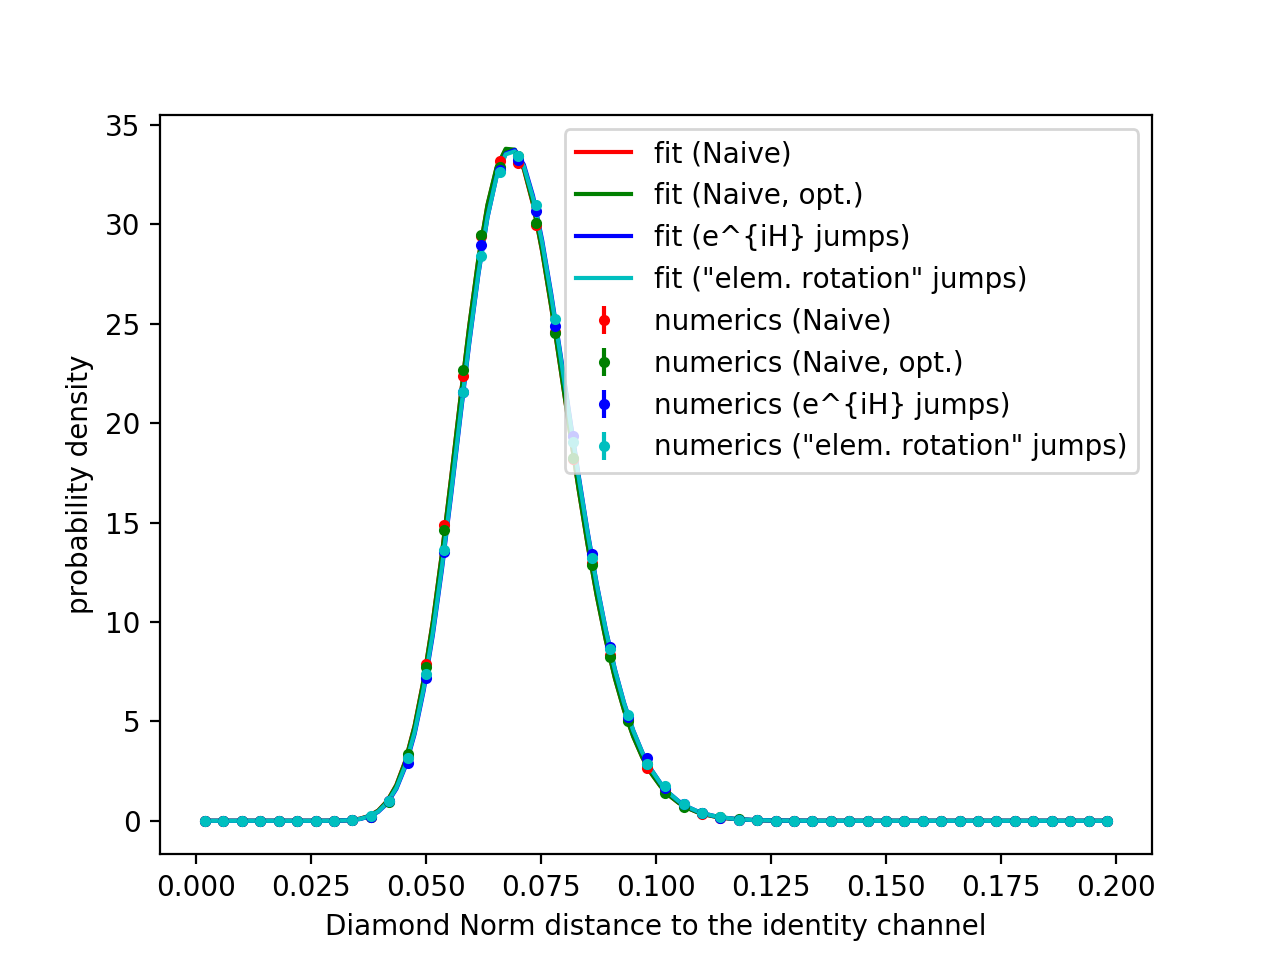

<IPython.core.display.Javascript object>


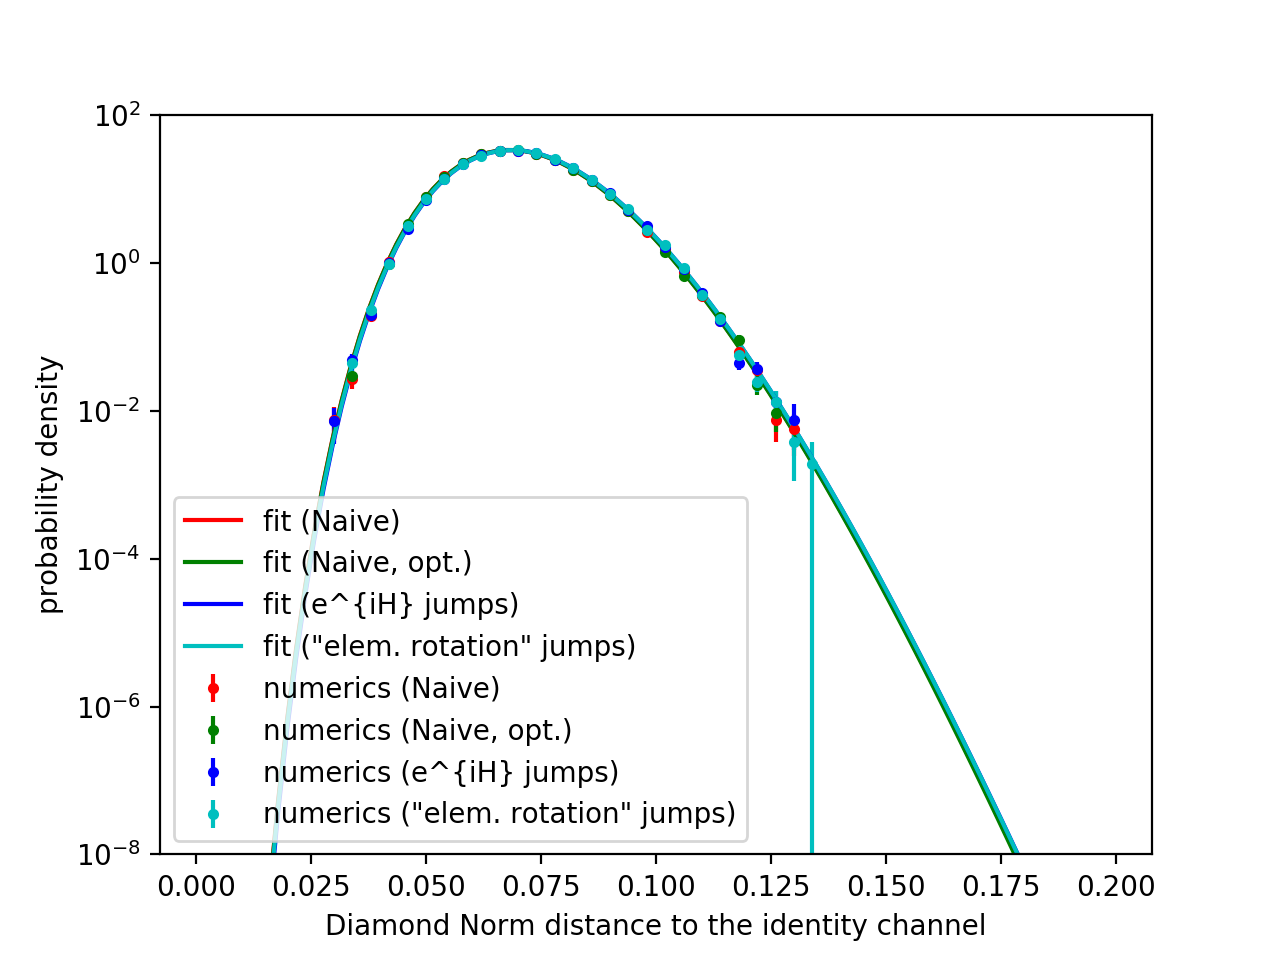

In [23]:
do_comparison_plot([a_naive, a_naiveopt, a_eiH, a_elr])

do_comparison_plot([a_naive, a_naiveopt, a_eiH, a_elr], log_scale=True)

## entanglement fidelity

<IPython.core.display.Javascript object>


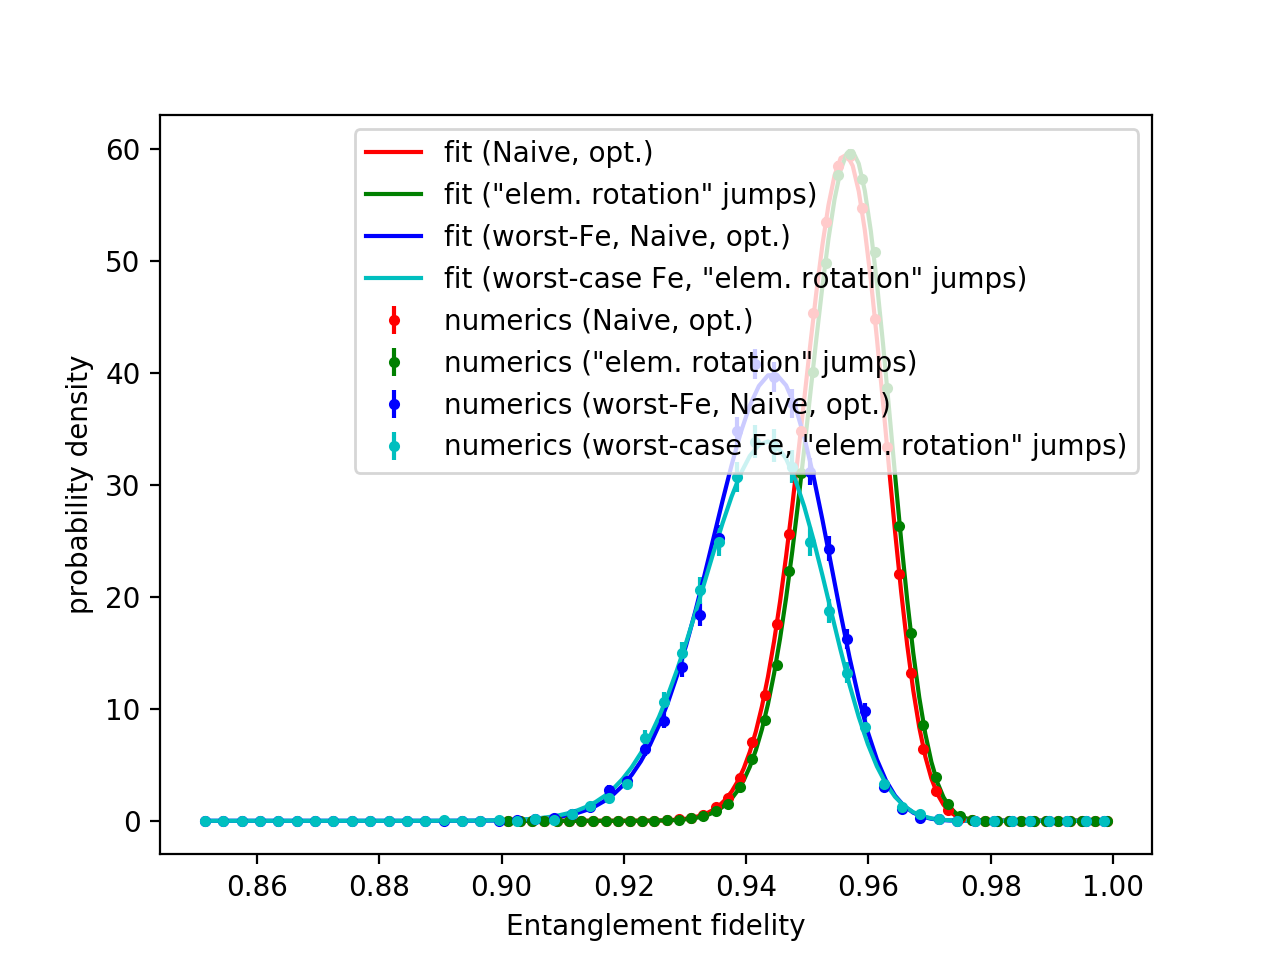

<IPython.core.display.Javascript object>


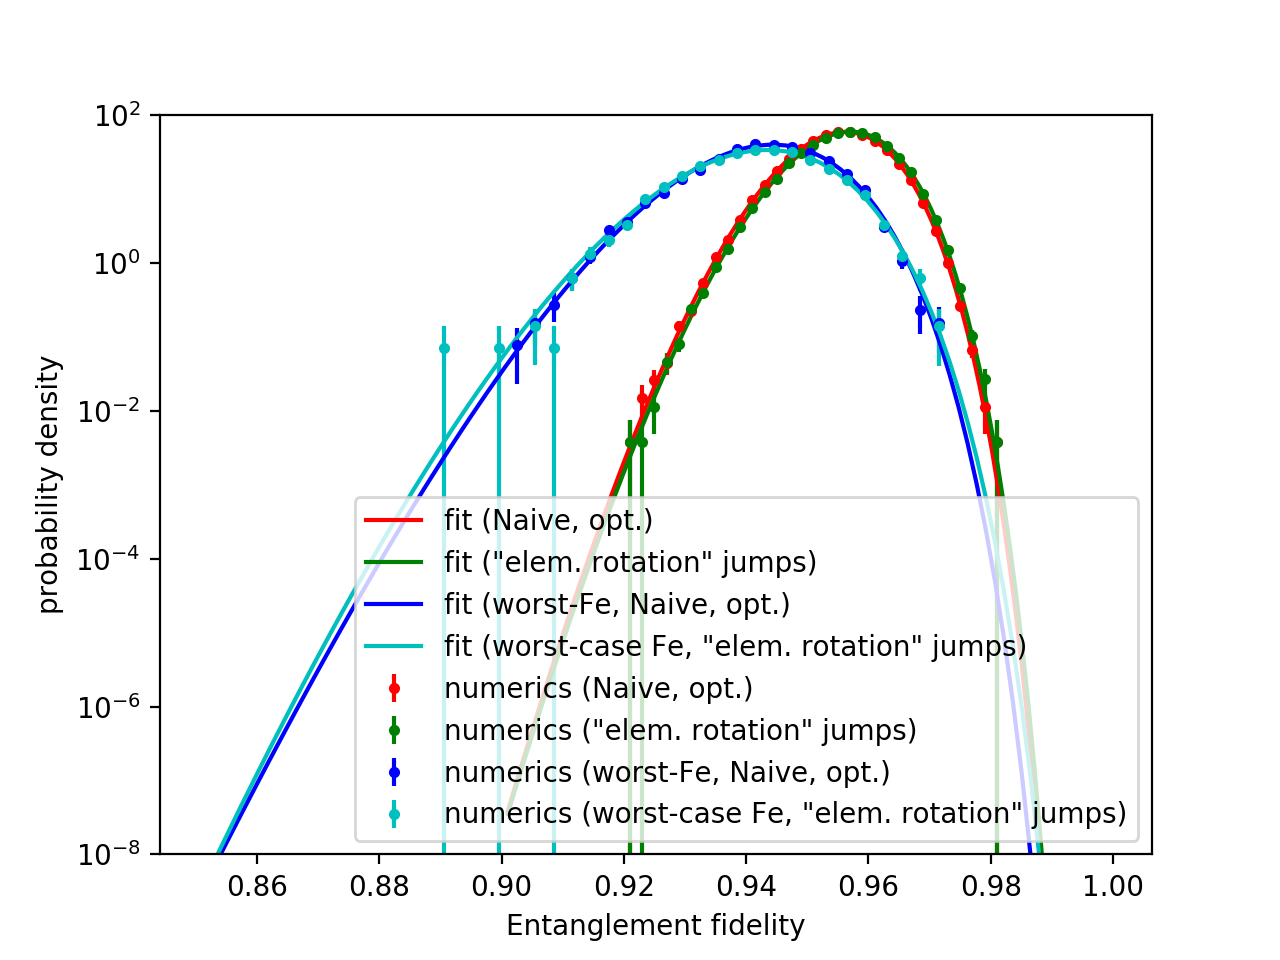

In [24]:
do_comparison_plot([a_Fe_naiveopt, a_Fe_elr, a_wFe_naiveopt, a_wFe_elr],
                   xlabel='Entanglement fidelity')

do_comparison_plot([a_Fe_naiveopt, a_Fe_elr, a_wFe_naiveopt, a_wFe_elr],
                   xlabel='Entanglement fidelity', log_scale=True)

Fit parameters:
          a2 = 1149.93
          a1 = -22.792
           m = 0.0415507
           p = 4.8538
           c = 12.333


<IPython.core.display.Javascript object>


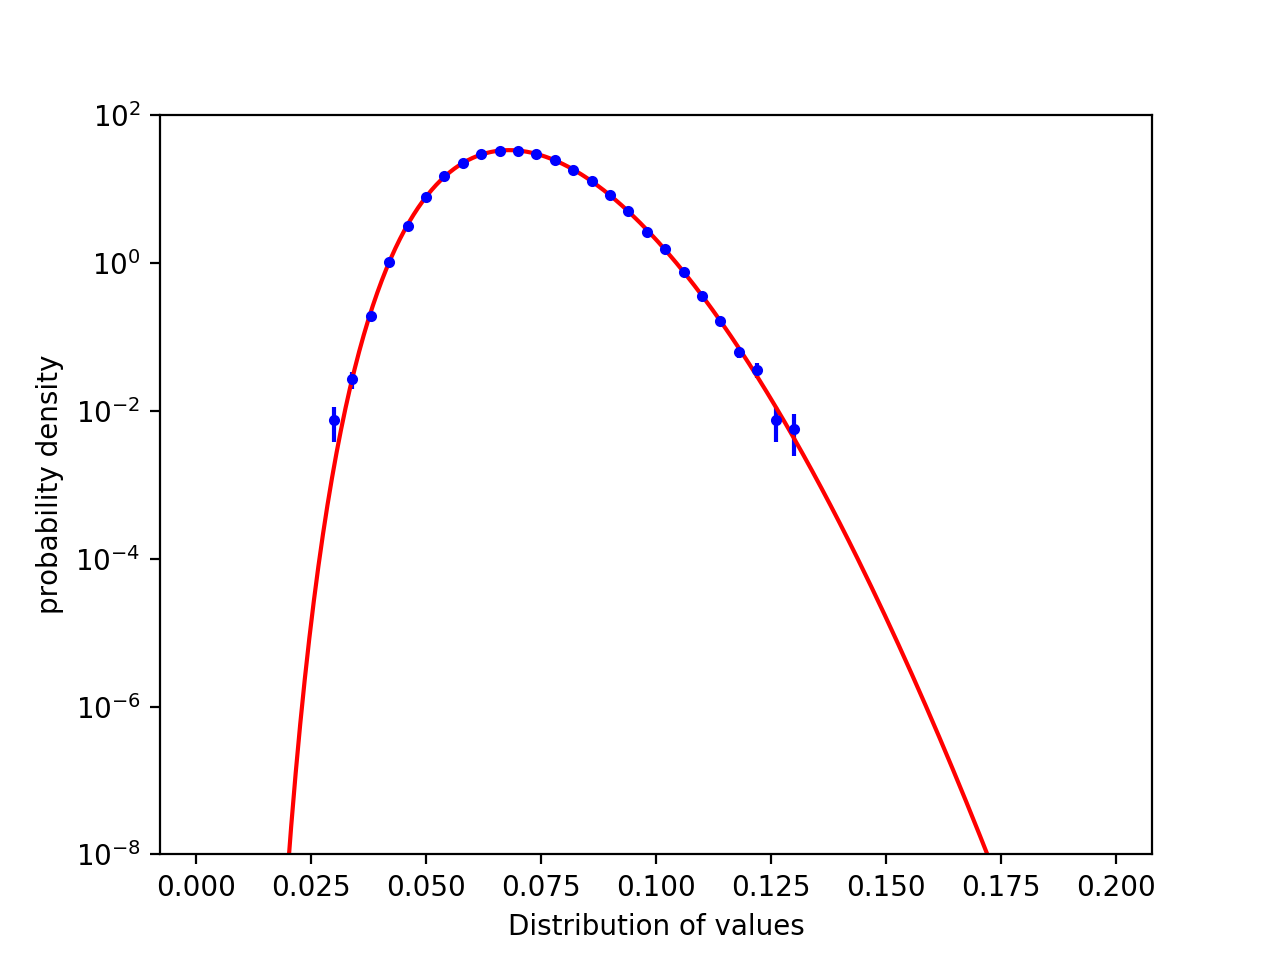

In [25]:
def fit_fn_n2(x, a2, a1, m, p, c):
    return -a2*np.square(x)-a1*x - m*np.power(-np.log(x), p) + c

r = r_naive
a = tomographer.querrorbars.HistogramAnalysis(
    r['final_histogram'], fit_fn=fit_fn_n2,
    bounds=((0,-np.inf,0,-np.inf,0), np.inf),
    p0=(1,1,1,3,50), maxfev=100000,
)
a.printFitParameters()
dp = a.plot(plot_deskewed_gaussian=False, show_plot=False, log_scale=True)
dp.ax.set_ylim([1e-8, 1e2])
dp.show()


In [3]:
<a id='Generating-plots-for-the-paper'></a>

SyntaxError: invalid syntax (<ipython-input-3-43e60ce45028>, line 1)